## CS536: Pruning Decision Trees
#### Done by - Vedant Choudhary, vc389
The purpose of this problem set is to look at the effect of pruning on decision trees. As before, we need a generative model for data so that we can run repeatable experiments. Let ${(X_1, Y_1),(X_2, Y_2), . . . ,(X_m, Y_m)}$ denote a data set, where $X_i$ represents a vector of k (binary) feature values, and $Y_i$ is a corresponding binary class or label that we will need to learn to be able to predict from the X-values.
We generate data via the following scheme, defining a distribution for our data set: Let $X = (X_0, X_1, X_2, X_3, . . . , X_{20})$
be a vector of binary values, satisfying the following
- $X_0 = 1$ with probability 1/2, $X_0 = 0$ with probability 1/2
- For i = 1, . . . , 14, $X_i = X_{i−1}$ with probability 3/4, and $X_i = 1 − X_{i−1}$ with probability 1/4.
- For i = 15, . . . , 20, $X_i = 1$ with probability 1/2, and $X_i = 0$ with probability 1/2.

The first feature value is uniformly random, and the next 14 features are strongly correlated, but the last 5 features are independent of everything else. There are 21 X-variables, so there are $2^{21} ≈ 2$ mil possible input X. Some of these are more likely than others. In general, we expect the training data to cover only a fraction of the total possible inputs, so consider data sets of size m where m ranges from 10 to 10,000. We then define Y to be

$$Y = majority(X_1, ....., X_7) if X_0 = 0$$
$$Y = majority(X_8, ....., X_{14}) if X_0 = 1$$

That is, if $X_0 = 0$, we take the majority value of $X_1$ through $X_7$ - otherwise we take the majority value of $X_8$ through
$X_{14}$. The values $X_{15}$ through $X_{20}$ are nothing but noise.

#### 1. Write a function to generate m samples of (X, Y), and another to fit a tree to that data using ID3. Write a third function to, given a decision tree f, estimate the error rate of that decision tree on the underlying data, err(f). Do this repeatedly for a range of m values, and plot the ‘typical’ error of a tree trained on m data points as a function of m. Does this agree with your intuition?

In [109]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm
from collections import Counter
from statistics import mode
from multiprocessing import Pool

%matplotlib inline

In [110]:
# Creating X (feature) vectors for the data
def create_data(k, m):
    X = [[0]*k for i in range(m)]
    for i in range(m):
        X[i][0] = int(np.random.choice(2, size=1))
        for j in range(1, k):
            if j <=14:
                temp = np.random.choice(2, 1, p=[0.25,0.75])
                if temp == 1:
                    X[i][j] = X[i][j-1]
                else:
                    X[i][j] = 1 - X[i][j-1]
            else:
                temp = np.random.choice(2, 1, p=[0.5,0.5])
                X[i][j] = int(temp)
    return X 

# Return most common value
def majority(l):
    occurence = Counter(l)
    return occurence.most_common(1)[0][0]

# Creating target column for the data
def create_y(X, k, m):
    y = []
    for i in range(m):
        if X[i][0] == 0:
            y.append(majority(X[i][1:8]))
        elif X[i][0] == 1:
            y.append(majority(X[i][8:15]))
    return y

# Combining all the sub data points into a dataframe
def create_dataset(k, m):
    X = np.asarray(create_data(k, m))
    y = np.asarray(create_y(X, k, m)).reshape(m, 1)

    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(k)]+['Y'])
    return data

In [111]:
# Global variables, k - number of features, m - sample size, epsilon - a very small value (e-16) used to avoid divide by zero errors
k, m = 21, 200
epsilon = np.finfo(float).eps

train_data = create_dataset(k, m)
train_data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,0,1,1,1,1,0,0,0,0,0,...,1,0,0,1,0,1,1,1,1,1
1,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,1,1,1,0,0,0
2,1,1,0,0,1,1,1,0,0,1,...,1,0,0,0,0,1,0,1,0,1
3,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,0,1,0,0,1
4,0,0,1,1,1,1,0,1,1,0,...,0,0,1,0,1,1,0,0,1,1


In [112]:
# Class for Decision Tree
class DecisionTree(): 
    '''
    Entropy function calculates the entropy of unique values in the target data i.e. entropy for 0 and 1
    Input - dataset
    Return - Entropy value for target
    '''
    def entropy(self, data):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
        entropy_y = 0
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
        
        for val in target_vals:
            p = data[target].value_counts()[val]/len(data[target])
            entropy_y += -p*np.log2(p)
        return entropy_y
    
    '''
    Calculates the conditional entropy of the target variable w.r.t to the features i.e. H(Y|X)
    Input - dataset, feature
    Return - Conditional entropy    
    '''
    def conditional_entropy(self, data, feature):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
#         Listing the unique values of current feature variable, here it is 0 and 1
        feature_vals = data[feature].unique()
        cond_entropy_y = 0
        
#         Going over the unique values of current feature, and calculation the cross-entropy
        for fval in feature_vals:
            entropy = 0
            for tval in target_vals:
#                 num calculates the number of data points that satisfy the feature and target values. Example - data points which have y as 0 and x as 0
                num = len(data[feature][data[feature] == fval][data[target] == tval])
#                 denom calculates the total number of data points satisfying feature = 0 or 1 (depends on fval)
                denom = len(data[feature][data[feature] == fval])
                e = num/(denom + epsilon)
                entropy += -(e)*np.log2(e + epsilon)
            cond_entropy_y += -(denom/len(data))*entropy
            
        return abs(cond_entropy_y)
    
    '''
    Calculates information gain value
    Input - dataset
    Return - max value of information gain feature
    '''
    def information_gain_split(self, data):
        IG = []
#         For every feature except the last column(y) in the dataset
        for key in data.keys()[:-1]:
            IG.append(self.entropy(data) - self.conditional_entropy(data, key))
            
        return data.keys()[:-1][np.argmax(IG)]
    
    '''
    Trims down the dataset as per the information gain node. Helps in building tree
    Input - dataset, node(which is the best split feature), val is either 0 or 1
    Return - trimmed dataset
    '''
    def get_subset(self, data, node, value):
        return data[data[node] == value].reset_index(drop=True)
    
    '''
    Get frequency of Y
    '''
    def get_freq(self, subset):
        target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
        if len(target_counts) == 1:
            return target_val[0]
        else:
            if target_counts[1] > target_counts[0]:
                return target_val[1]
            else:
                return target_val[0]
    
    '''
    Builds the decision tree based on functions written above. It is a recursive function till leaf nodes found
    Input - dataset
    Return - the built decision tree, in a dictionary like format
    '''
    def build_tree(self, data, tree=None):
        target = data.keys()[-1]
        best_split = self.information_gain_split(data)
        feature_vals = data[best_split].unique()
        
        if tree is None:
            tree = {}
            tree[best_split] = {}
        
        for val in feature_vals:
            subset = self.get_subset(data, best_split, val)
            target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
            if len(target_counts) == 1:
                tree[best_split][val] = target_val[0]
            else:
                tree[best_split][val] = self.build_tree(subset)        
        
        return tree
    
    def calculate_chi_sqaure(self, data, best_split, target, feature_vals):
        n = len(data)
        t_statistic = []
        for fval in feature_vals:
            for tval in feature_vals:
                e_xy = (data[best_split].value_counts()[fval]*data[best_split].value_counts()[tval])/n
                o_xy = data[(data[best_split]==fval)&(data[target]==tval)].shape[0]
                total = (e_xy - o_xy)**2/e_xy
                t_statistic.append(total)
                
        return sum(t_statistic)
    
    def prune_by_significance(self, data, sig, tree=None):
        target = data.keys()[-1]
        best_split = self.information_gain_split(data)
        feature_vals = data[best_split].unique()
        if tree is None:
            tree = {}
            tree[best_split] = {}
            
        for val in feature_vals:
            t_sig = self.calculate_chi_sqaure(data, best_split, target, feature_vals)
            if t_sig <= sig:
#                 print(best_split, t_sig)
                tree[best_split][val] = self.get_freq(data)
            else:
                subset = self.get_subset(data, best_split, val)
                target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
                if len(target_counts) == 1:
                    tree[best_split][val] = target_val[0]
                else:
                    tree[best_split][val] = self.prune_by_significance(subset, sig)
        return tree
    
    def prune_by_sample_size(self, data, s, tree=None):
        target = data.keys()[-1]
        best_split = self.information_gain_split(data)
        feature_vals = data[best_split].unique()
        if tree is None:
            tree = {}
            tree[best_split] = {}
            
        for val in feature_vals:
            if len(data) <= s:
                tree[best_split][val] = self.get_freq(data)
            else:
                subset = self.get_subset(data, best_split, val)
                target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
                if len(target_counts) == 1:
                    tree[best_split][val] = target_val[0]
                else:
                    tree[best_split][val] = self.prune_by_sample_size(subset, s)
        return tree
    
    '''
    Predicts the target value based on a data vector
    Input - a single row of dataset or a single X vector, decision tree
    Return - predicted value
    '''
    def predict(self, instance_data, tree):
        for node in tree.keys():
            value = instance_data[node]
            tree = tree[node][value]
            prediction = 0
            
            if type(tree) is dict:
                prediction = self.predict(instance_data, tree)
            else:
                prediction = tree
                break
        
        return prediction
    
    '''
    Predicts the target value and then calculates error based on the predictions
    Input - dataset, decision tree built
    Return - error
    '''
    def fit(self, data, tree):
        error = 0
        for i in range(len(data)):
            prediction = self.predict(data.iloc[i], tree)
            if prediction != data.iloc[i][-1]:
                error += 1
        return error/len(data)    
    
    '''
    Generates multiple datasets and finds error on those datasets
    Input - Built decision tree, feature values, sample size of dataset
    Return - typical error
    '''
    def generate_data_and_typical_error(self, tree, k, m):
        typical_error = 0
        for i in range(50):
            data = create_dataset(k, m)
            typical_error += self.fit(data, tree)

        typical_error = typical_error/50
        return typical_error

###### Decision tree with node has been made because I was not able to find depth in the tree I created before. I was having a hard time parsing through nested dictionaries, hence, I created a new DT class which uses a class Node. This has allowed me to solve problems related to depth.

In [121]:
class Node():
    def __init__(self,
                 data = None,
                 next_point = None,
                 child = None,
                 depth = None
                ):
        self.data = data
        self.next_point = next_point
        self.child = child
        self.depth = depth

In [126]:
class DecisionTreeWithNode():
    def __init__(self, parent = None, max_depth = None, min_sample_size = None, significance = None, temp = None):
        self.parent = parent
        self.max_depth = max_depth
        self.min_sample_size = min_sample_size
        self.significance = significance
        self.epsilon = np.finfo(float).eps
        if temp == None:
            self.temp = []
            
    '''
    Entropy function calculates the entropy of unique values in the target data i.e. entropy for 0 and 1
    Input - dataset
    Return - Entropy value for target
    '''
    def entropy(self, data):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
        entropy_y = 0
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
        
        for val in target_vals:
            p = data[target].value_counts()[val]/len(data[target])
            entropy_y += -p*np.log2(p)
        return entropy_y
    
    '''
    Calculates the conditional entropy of the target variable w.r.t to the features i.e. H(Y|X)
    Input - dataset, feature
    Return - Conditional entropy    
    '''
    def conditional_entropy(self, data, feature):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
#         Listing the unique values of current feature variable, here it is 0 and 1
        feature_vals = data[feature].unique()
        cond_entropy_y = 0
        
#         Going over the unique values of current feature, and calculation the cross-entropy
        for fval in feature_vals:
            entropy = 0
            for tval in target_vals:
#                 num calculates the number of data points that satisfy the feature and target values. Example - data points which have y as 0 and x as 0
                num = len(data[feature][data[feature] == fval][data[target] == tval])
#                 denom calculates the total number of data points satisfying feature = 0 or 1 (depends on fval)
                denom = len(data[feature][data[feature] == fval])
                e = num/(denom + self.epsilon)
                entropy += -(e)*np.log2(e + self.epsilon)
            cond_entropy_y += -(denom/len(data))*entropy
            
        return abs(cond_entropy_y)
    
    '''
    Calculates information gain value
    Input - dataset
    Return - max value of information gain feature
    '''
    def information_gain_split(self, data):
#         For every feature except the last column(y) in the dataset
        IG = [(key, self.entropy(data) - self.conditional_entropy(data, key)) for key in data.keys()[:-1]]
        if len(IG) != 0:
            return max(IG, key = lambda val: val[1])
        else:
            return (0,0)
    
    '''
    Calculates the value of t-test between a feature and target
    '''
    def calculate_chi_sqaure(self, data, best_split, target):
        n = len(data)
        t_statistic = []
        feature_vals = data[best_split].unique()
        for fval in feature_vals:
            for tval in feature_vals:
                e_xy = (data[best_split].value_counts()[fval]*data[best_split].value_counts()[tval])/n
                o_xy = data[(data[best_split]==fval)&(data[target]==tval)].shape[0]
                total = (e_xy - o_xy)**2/e_xy
                t_statistic.append(total)
                
        return sum(t_statistic)    
    
    '''
    Trims down the dataset as per the information gain node. Helps in building tree
    Input - dataset, node(which is the best split feature), val is either 0 or 1
    Return - trimmed dataset
    '''
    def get_subset(self, data, node):
        return [Node(data = (data[data[node] == val].drop(node, axis=1)),
                     next_point = (node, val)) for val in data[node].unique()]
    
    '''
    Build the tree
    '''
    def fit(self, data, target):
#         Initiate node if not present
        if type(data) != Node:
            data = Node(data = data, depth = 0)
            self.parent = data
        
#         Terminate if no data found for the subset
        if self.get_subset(data.data, target)[1] == 0 :
            return
        
        if self.max_depth != None:
            if data.depth == self.max_depth:
                return
            
        if self.min_sample_size != None:
            if data.data.shape[0] <= self.min_sample_size:
                return
        
        best_split = self.information_gain_split(data.data)[0]
        
        if self.significance != None:
            if self.calculate_chi_sqaure(data.data,best_split,target) < self.significance:
                return
        
        data.child = self.get_subset(data.data, best_split)
        for cnode in data.child:
            cnode.depth = data.depth + 1
               
        for cnode in data.child:
            if cnode.data['Y'].nunique() != 1:
                self.fit(cnode, target)
            
    def get_next(self, tree_model = None ,next_list = None):
        if next_list == None:
            next_list = []
        
        if tree_model == None:
            tree_model = self.parent
        next_list.append(tree_model.next_point)
        
        if tree_model.child == None:
            next_list.append(tree_model['Y'].mode()[0])
            return print(next_list[1:])
        
        for cnode in tree_model.child:
            self.get_next(cnode, next_list.copy())
     
    '''
    Getting irrelevant variables in the tree by checking them with known irrelevant variables
    '''
    def get_irrelevant_variable(self, irrelevant_variables, tree_model = None ):
        if tree_model == None:
            tree_model = self.parent
        
        if tree_model.child == None:
            return
        
        for cnode in tree_model.child:
            if cnode.next_point[0] in irrelevant_variables:
                self.temp.append(cnode.next_point[0])
            self.get_irrelevant_variable(irrelevant_variables,cnode)
        
        return list(set(self.temp))
    
    '''
    Predicts the target value based on a data vector
    Input - a single row of dataset or a single X vector, decision tree
    Return - predicted value
    '''
    def predict_row(self, tree, instance_data):
        if tree.child == None:
            return(tree.data['Y'].mode()[0])

        var = tree.child[0].next_point[0]
        row_val = instance_data[var]
        
        for cnode in tree.child:
            if cnode.next_point[1] == row_val:
                return self.predict_row(cnode, instance_data)
            
    def predict(self, data):
        prediction = []
        for row in data.iterrows():
            x = row[1]
            y = self.predict_row(self.parent, x)
            prediction.append(y)
        
        return pd.Series(prediction)
    
    def training_error(self):
        predict_train = self.predict(self.parent.data)
        return (1 - sum(self.parent.data['Y'] == predict_train) / len(self.parent.data))
    
    def error(self, test, target):
        predict_test = self.predict(test.drop(target, axis = 1))
        return (1 - sum(test[target] == predict_test)/ len(test))
    
    def typical_error(self, tree, m):
        typical_error = []
        for i in range(50):
            data = create_dataset(k, m)
            predicted = tree.predict(data)
            error = 1 -(sum(data.keys()[:-1] == predicted)/ len(data))
            typical_error.append(error)
        return typical_error

In [113]:
dt = DecisionTree()
tree = dt.build_tree(train_data)
tree

{'X6': {0: {'X1': {1: {'X11': {0: {'X0': {0: {'X2': {1: 1, 0: 0}}, 1: 0}},
      1: {'X9': {0: {'X14': {0: 0,
          1: {'X0': {0: {'X2': {0: 0, 1: 1}}, 1: 1}}}},
        1: {'X12': {1: 1, 0: {'X14': {0: 0, 1: 1}}}}}}}},
    0: {'X13': {0: {'X14': {1: {'X5': {1: 1, 0: 0}}, 0: 0}},
      1: {'X0': {0: {'X3': {1: {'X7': {1: 1, 0: 0}}, 0: 0}},
        1: {'X10': {1: 1, 0: 0}}}}}}}},
  1: {'X13': {0: {'X3': {0: {'X2': {0: {'X4': {1: {'X1': {1: 1, 0: 0}}, 0: 0}},
        1: {'X0': {0: 1, 1: {'X5': {0: 1, 1: 0}}}}}},
      1: {'X0': {1: {'X10': {0: 0, 1: {'X1': {1: 1, 0: 0}}}},
        0: {'X5': {1: 1, 0: {'X4': {1: 1, 0: 0}}}}}}}},
    1: {'X9': {1: {'X0': {1: 1,
        0: {'X4': {1: {'X3': {1: 1,
            0: {'X1': {0: {'X7': {0: 0, 1: 1}}, 1: 1}}}},
          0: 0}}}},
      0: {'X10': {0: {'X2': {0: {'X7': {1: {'X3': {1: 1,
              0: {'X0': {1: 1, 0: 0}}}},
            0: 0}},
          1: {'X12': {1: 0, 0: 1}}}},
        1: 1}}}}}}}}

In [114]:
error = dt.fit(train_data, tree)
error

0.0

In [115]:
# This function generates data depending on different values of m
def generate_data_varied_m(k):
    m = list(range(10, 2000, 100))
    train_errors = []
    errors = []

    for i in tqdm(range(len(m))):
        train_data = create_dataset(k, m[i])
        dt = DecisionTree()
        tree = dt.build_tree(train_data)
        train_error = dt.fit(train_data, tree)
        typical_error = dt.generate_data_and_typical_error(tree, k, m[i])
        errors.append(abs(train_error - typical_error))
        train_errors.append(train_error)
        
    plt.plot(m, errors)
    plt.xlabel("Value of m (sample size)")
    plt.ylabel("Abs. difference between training and true error")
    plt.title("Error difference as a function of m")
    plt.show()
    return errors, train_errors



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

 10%|█         | 2/20 [00:07<00:44,  2.46s/it]

 15%|█▌        | 3/20 [00:20<01:36,  5.67s/it]

 20%|██        | 4/20 [00:40<02:38,  9.92s/it]

 25%|██▌       | 5/20 [01:05<03:38, 14.57s/it]

 30%|███       | 6/20 [01:35<04:28, 19.21s/it]

 35%|███▌      | 7/20 [02:09<05:05, 23.51s/it]

 40%|████      | 8/20 [02:49<05:43, 28.59s/it]

 45%|████▌     | 9/20 [03:38<06:18, 34.45s/it]

 50%|█████     | 10/20 [04:31<06:42, 40.24s/it]

 55%|█████▌    | 11/20 [05:29<06:48, 45.35s/it]

 60%|██████    | 12/20 [06:31<06:43, 50.47s/it]

 65%|██████▌   | 13/20 [07:42<06:36, 56.60s/it]

 70%|███████   | 14/20 [08:55<06:09, 61.58s/it]

 75%|███████▌  | 15/20 [10:14<05:33, 66.70s/it]

 80%|████████  | 16/20 [11:37<04:47, 71.82s/it]

 85%|████████▌ | 17/20 [13:08<03:52, 77.56s/it]

 90%|█████████ | 18/20 [14:42<02:44, 82.26s/it]

 95%|█████████▌| 19/20 [16:25<01:28, 88.44s/it]

100%|██████████| 20/20 [18:04<00:00,

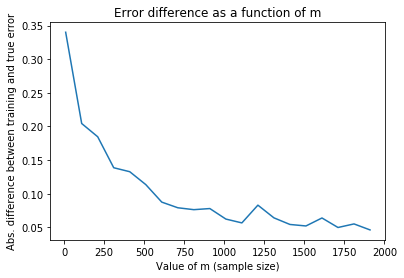

In [116]:
typical_error, train_error = generate_data_varied_m(k)

**Solution:** Yes, the graph agrees with our intuition. The reason the error is going down as sample size of the dataset is increased is because as the sample size increases, we are getting to see more of the true data representation of 20 features, $2^20 ~ 1 million$ data points. Ideally, if we go to or above 1 million sample points, our error should go towards zero. But, due to my laptop computation restrictions and time, I have only shown till 2000 (enough to understand the trend)

#### 2. Note that $X_{15}$ through $X_{20}$ are completely irrelevant to predicting the value of Y . For a range of m values, repeatedly generate data sets of that size and fit trees to that data, and estimate the average number of irrelevant variables that are included in the fit tree. How much data would you need, typically, to avoid fitting on this noise?

In [152]:
def irrelevant_vars(k):
    m = [100, 500, 1000, 2000, 5000, 10000, 30000, 50000,70000]
    irrelevant_count = []
    irrelevant_variable = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
    for i in tqdm(range(len(m))):
        count = []
        for j in range(10):
            train_data = create_dataset(k, m[i])
            dt = DecisionTreeWithNode()
            tree = dt.fit(train_data, 'Y')
            count.append(len(dt.get_irrelevant_variable(irrelevant_variable)))
            
        irrelevant_count.append(sum(count)/len(count))
    
    plt.plot(m, irrelevant_count)
    plt.xlabel("Value of m (sample size)")
    plt.ylabel("Count of irrelevant columns")
    plt.title("Irrelevant columns as a function of m")
    plt.show() 




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:22<03:01, 22.63s/it]


 22%|██▏       | 2/9 [01:29<04:11, 35.91s/it]


 33%|███▎      | 3/9 [03:18<05:47, 57.88s/it]


 44%|████▍     | 4/9 [06:10<07:40, 92.10s/it]


 56%|█████▌    | 5/9 [10:44<09:45, 146.49s/it]


 67%|██████▋   | 6/9 [16:42<10:29, 210.00s/it]


 78%|███████▊  | 7/9 [26:38<10:51, 325.79s/it]


 89%|████████▉ | 8/9 [38:58<07:30, 450.25s/it]


100%|██████████| 9/9 [54:11<00:00, 588.86s/it]




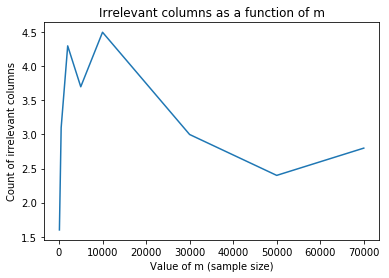

In [154]:
irrelevant_vars(k)

**Solution:** We can see from the graph generated, that we need more than ~12000 data points for irrelevant features to be of less noise. Once there is $2^{15}$ data points, the importance of these features should be minimum.

#### 3. Generate a data set of size m = 10000, and set aside 8000 points for training, and 2000 points for testing. The remaining questions should all be applied to this data set.

In [123]:
m1 = 10000
data2 = create_dataset(k, m1)
train2, test2 = data2[:8000].reset_index(drop = True), data2[8000:].reset_index(drop = True)

#### a. Pruning by Depth
Consider growing a tree as a process - running ID3 for instance until all splits up to depth d have been performed. Depth d = 0 should correspond to no decisions - a prediction for Y is made just on the raw frequencies of Y in the data. Plot, as a function of d, the error on the training set and the error on the test set for a tree grown to depth d. What does your data suggest as a good threshold depth?

In [127]:
def pruning_by_depth():
    depth = list(range(1, 20))
    train_error, test_error = [], []
    for i in tqdm(range(len(depth))):
        tree = DecisionTreeWithNode(max_depth=depth[i])
        tree.fit(train2, 'Y')
        train_error.append(tree.training_error())
        test_error.append(tree.error(test2, 'Y'))
        
    plt.plot(depth, train_error, marker='', color='blue', linewidth=2, label="Training error")
    plt.plot(depth, test_error, marker='', color='green', linewidth=2, linestyle='dashed', label="Testing error")
    plt.xlabel("Value of Depth Level")
    plt.ylabel("Errors")
    plt.title("Pruning by Depth Level")
    plt.legend()
    plt.show()



  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:02<00:36,  2.03s/it]

 11%|█         | 2/19 [00:04<00:36,  2.14s/it]

 16%|█▌        | 3/19 [00:07<00:37,  2.36s/it]

 21%|██        | 4/19 [00:12<00:47,  3.19s/it]

 26%|██▋       | 5/19 [00:21<01:07,  4.85s/it]

 32%|███▏      | 6/19 [00:34<01:34,  7.29s/it]

 37%|███▋      | 7/19 [00:51<02:05, 10.45s/it]

 42%|████▏     | 8/19 [01:15<02:37, 14.30s/it]

 47%|████▋     | 9/19 [01:42<03:01, 18.12s/it]

 53%|█████▎    | 10/19 [02:11<03:13, 21.49s/it]

 58%|█████▊    | 11/19 [02:41<03:12, 24.01s/it]

 63%|██████▎   | 12/19 [03:11<03:00, 25.74s/it]

 68%|██████▊   | 13/19 [03:40<02:40, 26.81s/it]

 74%|███████▎  | 14/19 [04:09<02:17, 27.53s/it]

 79%|███████▉  | 15/19 [04:39<01:53, 28.28s/it]

 84%|████████▍ | 16/19 [05:09<01:26, 28.69s/it]

 89%|████████▉ | 17/19 [05:39<00:58, 29.08s/it]

 95%|█████████▍| 18/19 [06:09<00:29, 29.46s/it]

100%|██████████| 19/19 [06:39<00:00, 29.65s/it]



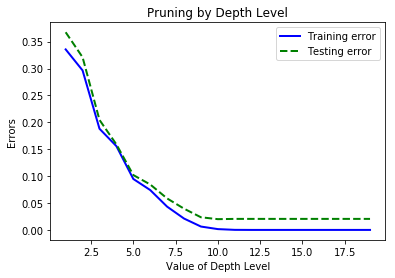

In [128]:
pruning_by_depth()

**Solution:** A good threshold depth is around the range 6-9 according to the graph generated. As we see in the graph, after a depth of 9, the training error almost drops to 0, but test error is still present. We can argue that at this stage, the model is overfitting and not generalizing.

#### b. Pruning by Sample Size: 
The less data a split is performed on, the less ‘accurate’ we expect the result of that split to be. Let s be a threshold such that if the data available at a node in your decision tree is less than or equal to s, you do not split and instead decide Y by simple majority vote (ties broken by coin flip). Plot, as a function of s, the error on the training set and the error on the testing set for a tree split down to sample size s. What does your data suggest as a good sample size threshold?

In [ ]:
def pruning_by_sample_size():
    s = list(range(10, 1000, 10))
    train_errors = []
    test_errors = []
    for i in tqdm(range(len(s))):
        tree = dt.prune_by_sample_size(train2, s[i])
        train_errors.append(dt.fit(train2, tree))
        test_errors.append(dt.fit(test2, tree))

    plt.plot(s, train_errors, marker='', color='blue', linewidth=2, label="Training error")
    plt.plot(s, test_errors, marker='', color='green', linewidth=2, linestyle='dashed', label="Testing error")
    plt.xlabel("Value of s (sample size for pruning)")
    plt.ylabel("Errors")
    plt.title("Pruning by Sample Size")
    plt.legend()
    plt.show()



  0%|          | 0/99 [00:00<?, ?it/s]

  1%|          | 1/99 [00:32<53:32, 32.78s/it]

  2%|▏         | 2/99 [01:03<51:50, 32.07s/it]

  3%|▎         | 3/99 [01:31<49:41, 31.06s/it]

  4%|▍         | 4/99 [01:59<47:24, 29.95s/it]

  5%|▌         | 5/99 [02:24<44:55, 28.67s/it]

  6%|▌         | 6/99 [02:49<42:45, 27.58s/it]

  7%|▋         | 7/99 [03:13<40:18, 26.28s/it]

  8%|▊         | 8/99 [03:36<38:26, 25.35s/it]

  9%|▉         | 9/99 [03:57<36:04, 24.05s/it]

 10%|█         | 10/99 [04:17<34:05, 22.98s/it]

 11%|█         | 11/99 [04:38<32:27, 22.14s/it]

 12%|█▏        | 12/99 [04:57<31:04, 21.44s/it]

 13%|█▎        | 13/99 [05:17<29:58, 20.91s/it]

 14%|█▍        | 14/99 [05:36<28:55, 20.42s/it]

 15%|█▌        | 15/99 [05:55<27:52, 19.91s/it]

 16%|█▌        | 16/99 [06:13<26:50, 19.40s/it]

 17%|█▋        | 17/99 [06:31<25:52, 18.94s/it]

 18%|█▊        | 18/99 [06:48<24:56, 18.47s/it]

 19%|█▉        | 19/99 [07:06<24:04, 18.06s/it]

 20%|██        | 20/99 [07:22<23:17,

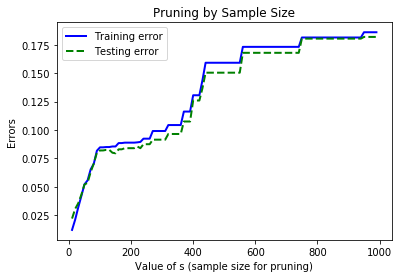

In [120]:
pruning_by_sample_size()

**Solution:** As can be seen from the graph generated, with increase in the minimum sample size required for splitting, the error in both training and test increases. This is because if we are increasing the min. sample size, we are basically increasing the probability of the model to predict the target by just doing majority. This should not be done. We should split the data on different features such that the model is more general and optimal.

In inital stages of graph, the errors are low, but that can be described by the overfitting nature of decision trees as the model is splitting nodes into a lot of features. At the end of the graph, the model relies heavly on predicting by majority, making it lose its predictive power. So, a good min. sample size should be somewhere in between.

We can say that for this example, a good min. sample size is in the range 50-100.

#### c. Pruning by Significance: 
If a variable X is independent of Y, then X has no value as a splitting variable. We can use something like the $χ^2$-test to estimate how likely a potential splitting variable is to be independent, based on the test statistic T compared to some threshold $T_0$ (in the usual 2-outcome case, $T_0$ = 3.841 is used to test at a significance level of p = 5% - see notes for more explanation). Given $T_0$, if given the data for X the value of T is less than $T_0$, it is deemed not significant and is not used for splitting. If given the data for X the value of T is greater than $T_0$, it is deemed significant, and used for splitting. Plot, as a function of $T_0$, the error on the training set and the error on the testing set for a tree split at significance threshold $T_0$. What does your data suggest as a good threshold for significance?

In [155]:
def pruning_by_significane():
    sig = list(np.arange(0, 20, 0.5))
    train_error, test_error = [], []
    for i in tqdm(range(len(sig))):
        tree = DecisionTreeWithNode(significance=sig[i])
        tree.fit(train2, 'Y')
        train_error.append(tree.training_error())
        test_error.append(tree.error(test2, 'Y'))
        
    plt.plot(sig, train_error, marker='', color='blue', linewidth=2, label="Training error")
    plt.plot(sig, test_error, marker='', color='green', linewidth=2, linestyle='dashed', label="Testing error")
    plt.xlabel("Value of Significance Level")
    plt.ylabel("Errors")
    plt.title("Pruning by Significance Level")
    plt.legend()
    plt.show()




  0%|          | 0/40 [00:00<?, ?it/s]


  2%|▎         | 1/40 [00:29<18:51, 29.02s/it]


  5%|▌         | 2/40 [00:59<18:36, 29.38s/it]


  8%|▊         | 3/40 [01:27<18:00, 29.19s/it]


 10%|█         | 4/40 [01:56<17:27, 29.09s/it]


 12%|█▎        | 5/40 [02:25<16:55, 29.02s/it]


 15%|█▌        | 6/40 [02:54<16:24, 28.95s/it]


 18%|█▊        | 7/40 [03:23<15:52, 28.87s/it]


 20%|██        | 8/40 [03:50<15:12, 28.52s/it]


 22%|██▎       | 9/40 [04:18<14:35, 28.24s/it]


 25%|██▌       | 10/40 [04:45<13:57, 27.92s/it]


 28%|██▊       | 11/40 [05:12<13:21, 27.65s/it]


 30%|███       | 12/40 [05:42<13:10, 28.23s/it]


 32%|███▎      | 13/40 [06:11<12:51, 28.56s/it]


 35%|███▌      | 14/40 [06:40<12:28, 28.77s/it]


 38%|███▊      | 15/40 [07:09<12:00, 28.83s/it]


 40%|████      | 16/40 [07:38<11:30, 28.79s/it]


 42%|████▎     | 17/40 [08:07<11:00, 28.71s/it]


 45%|████▌     | 18/40 [08:35<10:28, 28.55s/it]


 48%|████▊     | 19/40 [09:02<09:53, 28.28s/it]


 50%|█████     

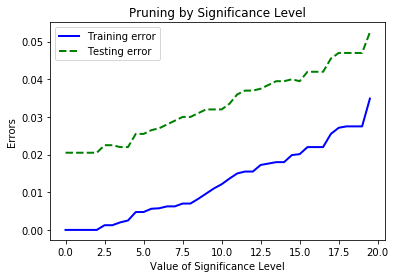

In [156]:
pruning_by_significane()

**Solution:** From the graph generated above, we can safely say that as we increase the significance level for chi-square test or T0, more and more variables are not considered in the tree, leading to error in the model. At the value range of T0 = 3.841-4.5, we see that the error rate in both training and testing is constant. So, a value from this range seems to be a good threshold 

#### 5. Repeat the computation of Problem 2, growing your trees only to depth d as chosen in 3.a. How does this change the likelihood or frequency of including spurious variables in your trees?

In [131]:
def tree_with_fixed_depth():
    d = 7
    samples = [100, 600, 1500, 4500, 10000, 15000, 30000, 55000]
    irrelevant_count = []
    irrelevant_variable = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
    for i in tqdm(range(len(samples))):
        count = []
        for j in range(10):
            train_data = create_dataset(k, samples[i])
            dt = DecisionTreeWithNode(max_depth=d)
            tree = dt.fit(train_data, 'Y')
            count.append(len(dt.get_irrelevant_variable(irrelevant_variable)))
            
        irrelevant_count.append(sum(count)/len(count))
    
    plt.plot(samples, irrelevant_count)
    plt.xlabel("Value of m (sample size)")
    plt.ylabel("Count of irrelevant columns")
    plt.title("Irrelevant columns as a function of m")
    plt.show() 



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:19<02:19, 20.00s/it]

 25%|██▌       | 2/8 [01:27<03:24, 34.15s/it]

 38%|███▊      | 3/8 [03:08<04:30, 54.17s/it]

 50%|█████     | 4/8 [05:42<05:37, 84.35s/it]

 62%|██████▎   | 5/8 [09:28<06:20, 126.74s/it]

 75%|███████▌  | 6/8 [14:00<05:40, 170.18s/it]

 88%|████████▊ | 7/8 [20:15<03:51, 231.75s/it]

100%|██████████| 8/8 [29:40<00:00, 331.84s/it]



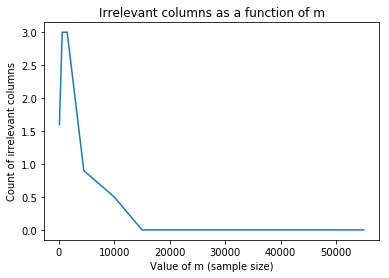

In [132]:
tree_with_fixed_depth()

**Solution:** As we see from the graph generated above, average number of irrelevant variables present in the model of the tree reduce as the sample size for the tree data grows, thereby proving that pruning the tree with respect to depth value is highly beneficial in removing noise. Pruning by depth decreases the count of irrelevant variables much faster than other pruning methods shown below.

#### 6. Repeat the computation of Problem 2, splitting your trees only to sample size s as chosen in 3.b. How does this change the likelihood or frequency of including spurious variables in your trees?

In [150]:
def tree_with_fixed_sample_size():
    sample_size = 50
    samples = [101, 500, 1000, 2500, 5000, 10000, 30000, 70000]
    irrelevant_count = []
    irrelevant_variable = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
    for i in tqdm(range(len(samples))):
        count = []
        for j in range(5):
            train_data = create_dataset(k, samples[i])
            dt = DecisionTreeWithNode(min_sample_size=sample_size)
            dt.fit(train_data, 'Y')
            count.append(len(dt.get_irrelevant_variable(irrelevant_variable)))
            
        irrelevant_count.append(sum(count)/len(count))
    
    plt.plot(samples, irrelevant_count)
    plt.xlabel("Value of m (sample size)")
    plt.ylabel("Count of irrelevant columns")
    plt.title("Irrelevant columns as a function of m")
    plt.show()




  0%|          | 0/8 [00:00<?, ?it/s]


 12%|█▎        | 1/8 [00:01<00:12,  1.72s/it]


 25%|██▌       | 2/8 [00:13<00:28,  4.80s/it]


 38%|███▊      | 3/8 [00:37<00:52, 10.58s/it]


 50%|█████     | 4/8 [01:24<01:25, 21.32s/it]


 62%|██████▎   | 5/8 [02:40<01:53, 37.82s/it]


 75%|███████▌  | 6/8 [04:43<02:06, 63.26s/it]


 88%|████████▊ | 7/8 [08:34<01:53, 113.62s/it]


100%|██████████| 8/8 [15:22<00:00, 201.98s/it]




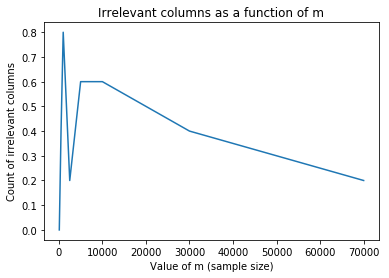

In [151]:
tree_with_fixed_sample_size()

**Solution:** As we see from the graph generated above, average number of irrelevant variables present in the model of the tree reduce as the sample size for the tree data grows, thereby proving that pruning the tree with respect to sample size is beneficial in removing noise. We see that the count of irrelevant variables keep on decreasing after ~10000 data points. It makes sense because if the samples are less, the data is not actually a true representation of the data.

#### 7. Repeat the computation of Problem 2, splitting your trees only at or above threshold level T0 as chosen in 3.c. How does this change the likelihood or frequency of including spurious variables in your trees?

In [146]:
def tree_with_fixed_significance():
    sig = 3.841
    samples = [100, 500, 1000, 2500, 5000, 10000, 50000, 75000]
    irrelevant_count = []
    irrelevant_variable = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
    for i in tqdm(range(len(samples))):
        count = []
        for j in range(5):
            train_data = create_dataset(k, samples[i])
            dt = DecisionTreeWithNode(significance=sig)
            tree = dt.fit(train_data, 'Y')
            count.append(len(dt.get_irrelevant_variable(irrelevant_variable)))
            
        irrelevant_count.append(sum(count)/len(count))
    
    plt.plot(samples, irrelevant_count)
    plt.xlabel("Value of m (sample size)")
    plt.ylabel("Count of irrelevant columns")
    plt.title("Irrelevant columns as a function of m")
    plt.show()




  0%|          | 0/8 [00:00<?, ?it/s]


 12%|█▎        | 1/8 [00:09<01:06,  9.44s/it]


 25%|██▌       | 2/8 [00:45<01:43, 17.28s/it]


 38%|███▊      | 3/8 [01:41<02:24, 28.99s/it]


 50%|█████     | 4/8 [03:16<03:15, 48.84s/it]


 62%|██████▎   | 5/8 [05:34<03:47, 75.74s/it]


 75%|███████▌  | 6/8 [08:57<03:47, 113.89s/it]


 88%|████████▊ | 7/8 [16:13<03:30, 210.44s/it]


100%|██████████| 8/8 [25:01<00:00, 305.75s/it]




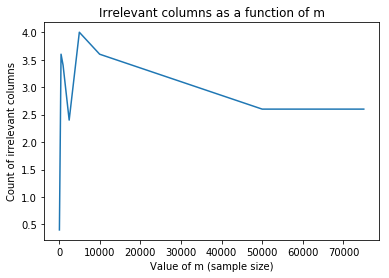

In [147]:
tree_with_fixed_significance()

**Solution:** As we see from the graph generated above, average number of spurious variables present in the model of the tree reduce as the sample size for the tree data grows, thereby proving that pruning the tree with respect to significance value is beneficial in removing noise.